### Energy ###

Energy J[i, j] between two nearest-neighbour acids that are not connected in the chain
<ul>
    <li>Combined contributions of VDW, covalent bonds, and water effects</li>
    <li>Depends on acid types of i and j</li>
    <li>Energy between non-nearest-neighbours taken to be 0</li>
    <li>Total energy of the protein is the sum over all non-covalently-bonded nearest neighbours (NBNN)</li>
    <li>Remember not to simply double-count pair energies</li>
    <li>Which acids are NBNN depends on the tertiary structure of the protein (Energy is a function of structure)</li>
</ul>


### Initialization ###

Before the actual simulation:
<ol>
    <li>Choose a (permanent) primary structure for the protein:
        <ol>
            <li>Determine length of protein chain (N)</li>
            <li>Decide (randomly) types of the N amino acids making up the chain (each link is an integer between 1 and 20)</li>
            <li>These integers will be stored in an array of length N, called A.</li>
        </ol>
    </li>
    <li>Specify interaction energies J<sub>i,j</sub> between the different types of acids:
        <ul>
            <li>20x20 matrix (20 different types) J</li>
            <li>Index J at i,j to get the interaction energy between acid types i and j</li>
            <li>We will assume that J<sub>i,j</sub> vary randomly withing some specified range (-4 to -2?)</li>
            <li><strong>Note: This can be changed. Setting J<sub>i,j</sub> to +-1 could be interesting</strong></li>
        </ul>
    </li>
    <li>Choose an initial tertiary structure for the protein:
        <ul>
            <li>Can be a completely straight chain</li>
            <li>Self-avoiding walk?</li>
        </ul>
    </li>
    <li>Put the protein on a sufficiently large lattice
</ol>

### Simulation ###

In one sweep of the protein, the following is done:

Note: Think about pre-generating random numbers outside of loops.
<ol>
    <li>Randomly select an acid, a, from A (by choosing a random number between 0 and N-1)</li>
    <li>This acid is said to have coordinates (x<sub>0</sub>, y<sub>0</sub>)</li>
    <li>Randomly select one of a's nearest neighbour positions (x<sub>n</sub>, y<sub>n</sub>)
        (<strong>Note: The text is unclear as to what constitutes a nearest neighbour. It says that each position has 4 
        nearest neighbours, but then says acids can transfer to a position diagonal to them - implying that each acid has 
        8 nearest neighbours, at least as far as transitions are concerned (for energy calculations, it seems to be the 
        classic 4 - see Figure 12.3)
        </strong>
    </li>
    <li>See if a could move to (x<sub>n</sub>, y<sub>n</sub>) without breaking a covalent bond</li>
    <li>If so, calculate the energy of the acid with its current neighbours, and that with its potential new neighbours</li>
    <li>If the change in energy is <strong>negative</strong>, move the acid</li>
    <li>Otherwise, move it probabilistically (if random num from 0-1 less than boltzmann factor exp(-dE/kT))</li>
    <li>Accumulate running sums for averages</li>
</ol>

This can be one MCS, or you can do this N times for one MCS.

After you do all sweeps, divide running sums by number of sweeps to get averages for the particular temperature at which 
the sweeps were performed.

Can investigate starting unfolded at a high temperature and seeing how Energy and Chain Length vary with temperature.

Can also investigate how an initially unfolded chain behaves at low temperature (Levinthal's paradox):
<ul>
    <li>Run simulation at low temperature on same chain multiple times</li>
    <li>Find time series of energy for each run (E vs Current MC step)</li>
    <li>Find that runs have different final energies (tertiary structures)</li>
    <li>In each case, protein was in "metastable" state, was not able to locate global minimum</li>
    <li>Actual protein is able to find global minimum from so many possible structures in no time!!!!!!!</li>
</ul>

How might we solve this paradox, and get the protein into the lowest energy state?

Annealing:
<ul>
    <li>Start the simulation at a very high temperature, allowing the protein to explore all of the configurations</li>
    <li>Slowly lower the temperature, so the protein will still fluctuate, but will spend increasing amounts of time 
    in the lowest-energy state</li>
    <li>When the final temperature is reached, hopefully the protein managed to sample a bunch of different states, and has 
    landed in the most stable one.</li>
</ul>

### Notes ###

<ul>
    <li>Measured quantities will likely be total energy and end-to-end length, where length is calculated as the pythagorean 
    difference between the coordinates of the acids on each end of the chain</li>
    <li>Should notice a fairly abrupt transition in these quantities around T = 2. Transition should get more abrupt with 
    larger chain (i.e. N = 100)</li>

### Take-away ###
<ul>
    <li>Our model does show a transition to a folded structure at low T</li>
    <li>We are not able to avoid getting trapped in meta-stable states, but annealing helps</li>
    <li>Annealing is less effective on longer (therefore more realistic) protein chains, since these chains have more possible 
    states, so can explore a smaller fraction of them in a given amount of time</li>
    <li>So how does nature seem to avoid Levinthal's paradox, and so quickly?
        <ul>
            <li>Maybe it doesn't</li>
            <li>Nature only uses a small portion of the possible primary structures</li>
            <li>It is possible that the ones used have energy surfaces that allow them to efficiently get to their unique 
            tertiary structure</li>
        </ul>
    </li>
</ul>

### Coding ###

<ul>
    <li>Collection of acids, A, will be numpy 1d-array of numpy 1d-arrays [type, x, y]</li>
    <li>Types will be random, created in the initialization period using numpy.random.randint()
    <li>Lattice will be numpy 2d-array holding the chain</li>
    
</ul>

## Initialization ##

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import math

In [233]:
T = 10
N = 15
MCS = 10000000


# Interaction energies between different types of acids
# Interaction energy between type i and type j is J[i-1, j-1]
J = np.random.uniform(-4, -2, size=(20, 20))


# Initially, no acids are non-bonded nearest-neighbours
E_chain = 0


# Make 2N by 2N lattice to ensure that the protein has rooom to fold
lattice = np.zeros(shape=(2*N,2*N), dtype=int)


# The type of each acid in the chain
types = np.random.randint(1, 21, size=N)


# Create x and y coordinates such that the chain will be horizontal, and centered in the 2N x 2N lattice
x_start = int(N/2)
x_end = int(3*N/2)
pos_xs = np.arange(x_start, x_end, dtype=int)
pos_ys = np.empty(N, dtype=int); pos_ys.fill(N)


# Zip type, x_pos, and y_pos to create array defining each acid (this is the protein)
for i in range(A.shape[0]):
    A[i] = np.array([types[i], pos_xs[i], pos_ys[i]])    
    
    
# Put protein on lattice
lattice[N, x_start:x_end] = types


# Pre-select random acid picks and random neighbour picks
acid_picks = np.random.randint(0, A.shape[0], size=MCS) # 1 acid picked from A each MCS
curr_acid_pick = 0

neighs = np.array([[-1,1], [-1,-1], [1,-1], [1,1]])

neigh_picks = np.random.randint(0, 4, size=MCS) # 1 acid picked from A each MCS
curr_neigh_pick = 0

## Monte Carlo Sweep ##

In [234]:
# Selects one acid, determines the change in energy from moving that acid, then either moves it or doesn't
def sweep(): 
    
    # Keep track of which random picks are to be used next
    global curr_acid_pick
    global curr_neigh_pick
    
    
    # Randomly select one acid in the chain
    acid = A[acid_picks[curr_acid_pick]]
    acid_x = acid[1]
    acid_y = acid[2]
    curr_acid_pick += 1
    
    
    # Randomly select a nearest neighbour
    neigh_index = neigh_picks[curr_neigh_pick]
    curr_neigh_pick += 1
    
    neigh_offset = neighs[neigh_index]
    
    neigh_pos = (acid_x+neigh_offset[0], acid_y+neigh_offset[1])
    
    neigh_val = lattice[neigh_pos[1], neigh_pos[0]]
    lattice[neigh_pos[1], neigh_pos[0]] = 40

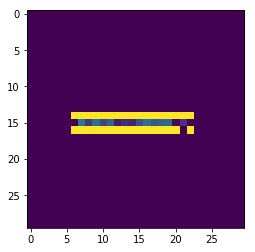

In [358]:
sweep()

# Show the protein on the lattice
plt.imshow(lattice)
plt.show()